In [2]:
import sys
import itertools
import random
import pandas as pd

# (Если нужно, добавляем путь к модулю)
sys.path.append('/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py')

# Импортируем нашу библиотеку
import microbiome_analysis as ma

# Настройка путей и переменных
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'rats_1'
GROUP_LIST = ['OB-BPD/DS ', 'VFGM-BPD/DS ', 'VFGM', 'CN/SD ']

DF = pd.read_csv(
    f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/out_data/{PART_OF_PATH}_out.csv',
    sep='\t',
    index_col=[0]
)

PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = True
SHOW = True

groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}

# Передаем параметры в библиотеку
ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE

ma.SAFE_DATA = SAFE_DATA
ma.SHOW = SHOW
ma.PALETTE = PALETTE
ma.NAME_DF = PART_OF_PATH
ma.GROUP_LIST = GROUP_LIST

# Пример использования функций из библиотеки:

# Например, визуализируем бета-разнообразие:
#ma.beta_diversity_visualization(DF, beta_diversity_method="braycurtis")


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

def filter_taxa_by_prevalence(df, 
                              abundance_col='RelativeAbundance', 
                              sample_col='#SampleID', 
                              taxonomy_col='Taxonomy',
                              presence_threshold=0.01, 
                              min_samples_fraction=0.1):
    n_samples = df[sample_col].nunique()
    presence_counts = (
        df[df[abundance_col] >= presence_threshold]
        .groupby(taxonomy_col)[sample_col]
        .nunique()
    )
    min_count = int(np.ceil(n_samples * min_samples_fraction))
    prevalent_taxa = presence_counts[presence_counts >= min_count].index
    filtered_df = df[df[taxonomy_col].isin(prevalent_taxa)].copy()
    return filtered_df

def remove_outliers_iqr(df, group_col, value_col, factor=1.5):
    filtered_list = []
    outliers_list = []
    
    for g, sub_df in df.groupby(group_col):
        Q1 = sub_df[value_col].quantile(0.25)
        Q3 = sub_df[value_col].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - factor * iqr
        upper = Q3 + factor * iqr
        
        mask = sub_df[value_col].between(lower, upper)
        filtered_list.append(sub_df[mask])
        outliers_list.append(sub_df[~mask])
    
    return pd.concat(filtered_list), pd.concat(outliers_list)

def test_taxa_kruskal_fdr(df, group_col='GROUP', value_col='RelativeAbundance', taxonomy_col='Taxonomy'):
    results = []
    unique_taxa = df[taxonomy_col].unique()

    for taxon in unique_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        grouped_data = [
            df_taxon.loc[df_taxon[group_col] == g, value_col].dropna().values
            for g in df[group_col].unique()
        ]
        if all(len(arr) > 0 for arr in grouped_data):
            stat, p_val = kruskal(*grouped_data)
            results.append((taxon, p_val))

    if len(results) > 0:
        taxa, pvals = zip(*results)
        pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
        results_df = pd.DataFrame({
            taxonomy_col: taxa,
            'p_value_raw': pvals,
            'p_value_fdr': pvals_corrected
        })
        return results_df.sort_values('p_value_fdr')
    else:
        return pd.DataFrame(columns=[taxonomy_col, 'p_value_raw', 'p_value_fdr'])



df_filtered = filter_taxa_by_prevalence(DF, 
                                        presence_threshold=0.01, 
                                        min_samples_fraction=0.1)


results_kruskal = test_taxa_kruskal_fdr(df_filtered, 'GROUP', 'RelativeAbundance', 'Taxonomy')
print(df_filtered.shape)

pivot_df = ma.melt_to_pivot(df_filtered)
alpha_df = ma.alpha_calculation(pivot_df)



(5985, 6)


/home/esp/data_analyze/general_venv/lib/python3.12/site-packages/skbio/util/_warning.py:60: UserWarning: observed_otus is deprecated as of 0.6.0.
  warn(f"{func.__name__} is deprecated as of {ver}.")



=== SHANNON ANOVA ===
              sum_sq     df        F    PR(>F)
C(GROUP)   2.538476    3.0  1.56019  0.202228
Residual  69.962289  129.0      NaN       NaN
=== SHANNON Tukey ===
        group1        group2  meandiff   p-adj   lower   upper  reject
0      CN/SD     OB-BPD/DS     0.1193  0.9332 -0.4019  0.6405   False
1      CN/SD           VFGM    0.0896  0.9628 -0.3934  0.5727   False
2      CN/SD   VFGM-BPD/DS     0.3434  0.1909 -0.1020  0.7888   False
3  OB-BPD/DS           VFGM   -0.0297  0.9988 -0.5473  0.4879   False
4  OB-BPD/DS   VFGM-BPD/DS     0.2241  0.6226 -0.2586  0.7068   False


/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:261: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GROUP', y=alpha_index, data=alpha_diversity_df,


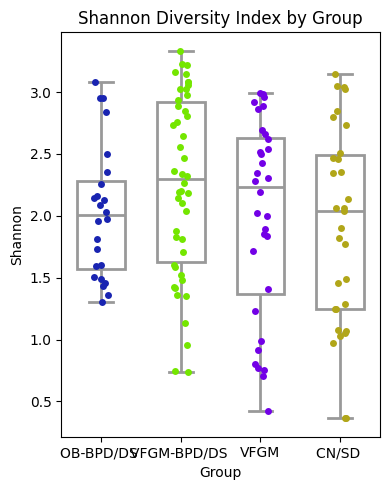


=== SIMPSON ANOVA ===
             sum_sq     df         F    PR(>F)
C(GROUP)  0.304944    3.0  2.565428  0.057451
Residual  5.111275  129.0       NaN       NaN
=== SIMPSON Tukey ===
        group1        group2  meandiff   p-adj   lower   upper  reject
0      CN/SD     OB-BPD/DS     0.1179  0.1350 -0.0230  0.2587   False
1      CN/SD           VFGM    0.0417  0.8394 -0.0889  0.1723   False
2      CN/SD   VFGM-BPD/DS     0.1097  0.0877 -0.0107  0.2301   False
3  OB-BPD/DS           VFGM   -0.0761  0.4913 -0.2160  0.0638   False
4  OB-BPD/DS   VFGM-BPD/DS    -0.0081  0.9985 -0.1386  0.1223   False


/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:261: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GROUP', y=alpha_index, data=alpha_diversity_df,


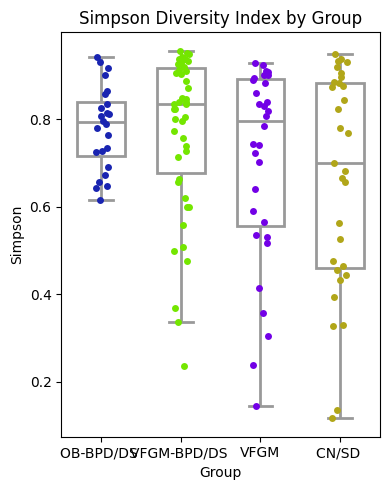


=== OBSERVED ANOVA ===
                sum_sq     df          F    PR(>F)
C(GROUP)   794.855561    3.0  10.901561  0.000002
Residual  3135.219627  129.0        NaN       NaN
=== OBSERVED Tukey ===
        group1        group2  meandiff   p-adj   lower   upper  reject
0      CN/SD     OB-BPD/DS    -6.3508  0.0000 -9.8396 -2.8620    True
1      CN/SD           VFGM   -1.3821  0.6826 -4.6158  1.8516   False
2      CN/SD   VFGM-BPD/DS     0.3829  0.9871 -2.5989  3.3646   False
3  OB-BPD/DS           VFGM    4.9688  0.0016  1.5038  8.4337    True
4  OB-BPD/DS   VFGM-BPD/DS     6.7337  0.0000  3.5026  9.9648    True


/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:261: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GROUP', y=alpha_index, data=alpha_diversity_df,


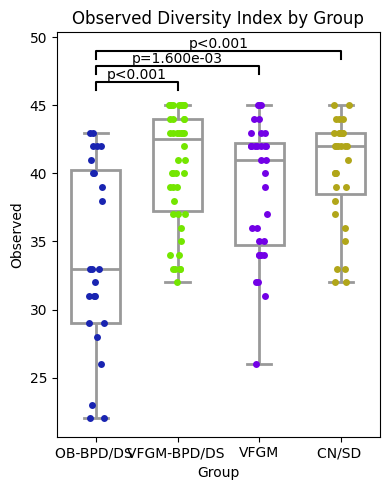


=== PIELOU_E ANOVA ===
             sum_sq     df         F    PR(>F)
C(GROUP)  0.163758    3.0  1.482899  0.222263
Residual  4.748527  129.0       NaN       NaN
=== PIELOU_E Tukey ===
        group1        group2  meandiff   p-adj   lower   upper  reject
0      CN/SD     OB-BPD/DS     0.0586  0.6758 -0.0772  0.1944   False
1      CN/SD           VFGM    0.0274  0.9418 -0.0985  0.1532   False
2      CN/SD   VFGM-BPD/DS     0.0887  0.1976 -0.0274  0.2047   False
3  OB-BPD/DS           VFGM   -0.0312  0.9311 -0.1661  0.1036   False
4  OB-BPD/DS   VFGM-BPD/DS     0.0301  0.9248 -0.0957  0.1558   False


/home/esp/data_analyze/05.02.2025/code/microbiome_analysis.py:261: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GROUP', y=alpha_index, data=alpha_diversity_df,


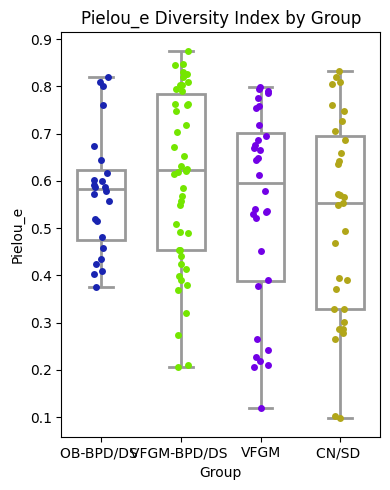

In [4]:
ma.alpha_all(alpha_df)

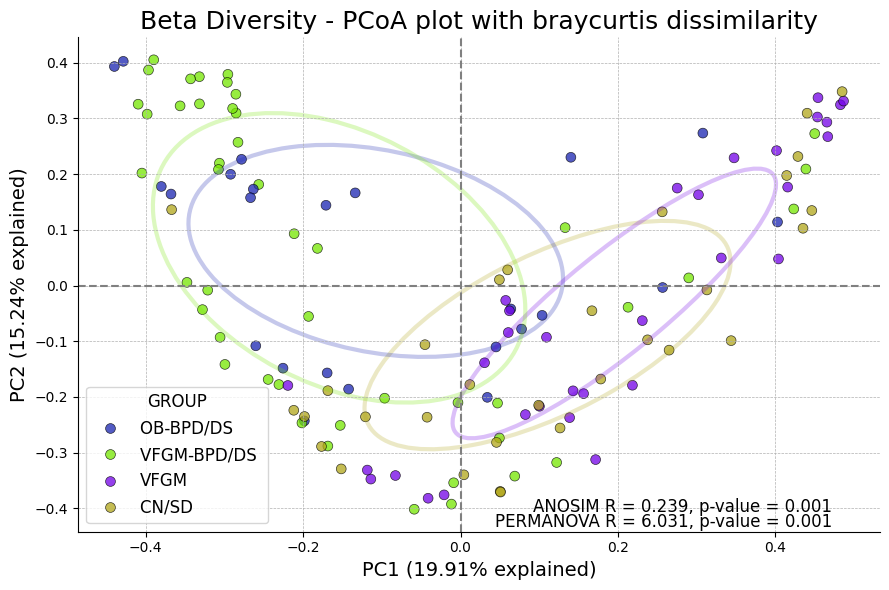

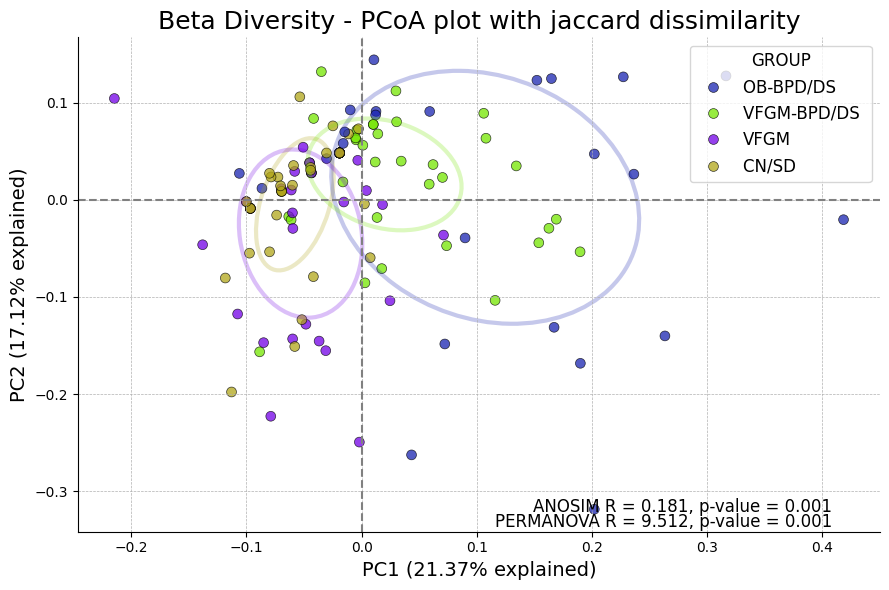

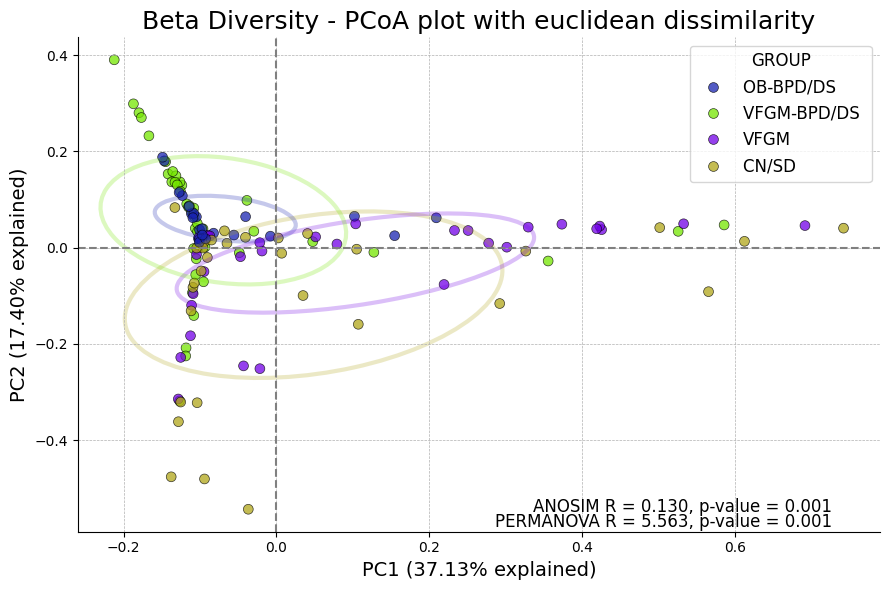

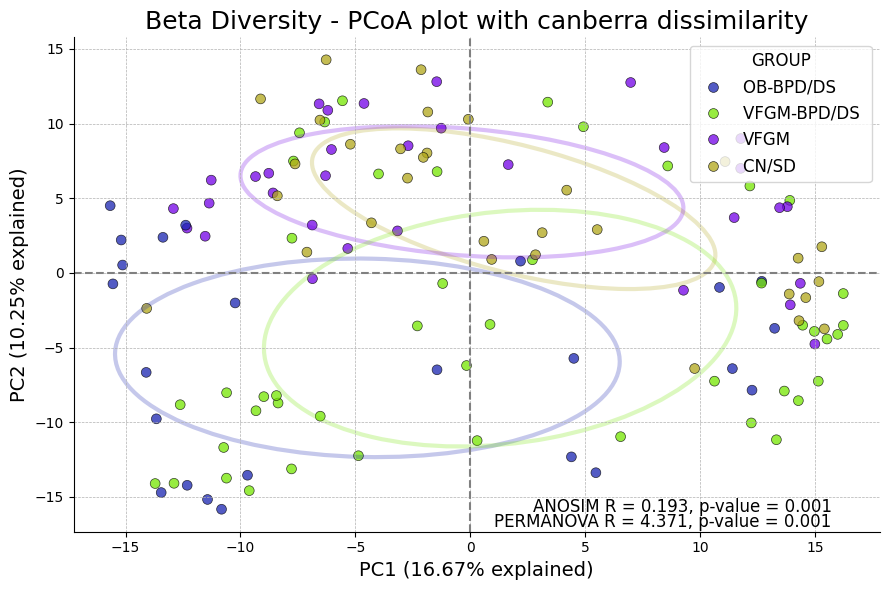

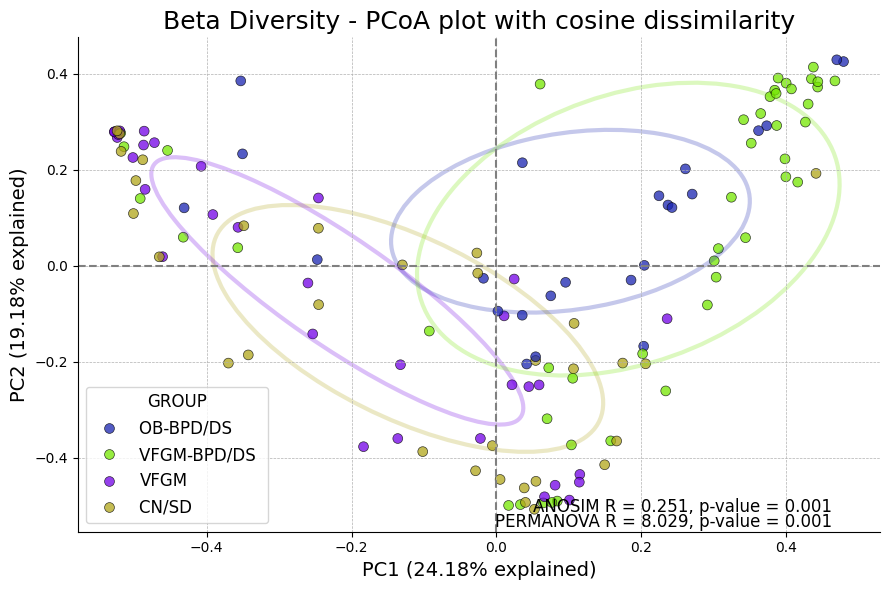

In [5]:
import warnings
warnings.filterwarnings('ignore')
ma.beta_diversity_all(df_filtered)

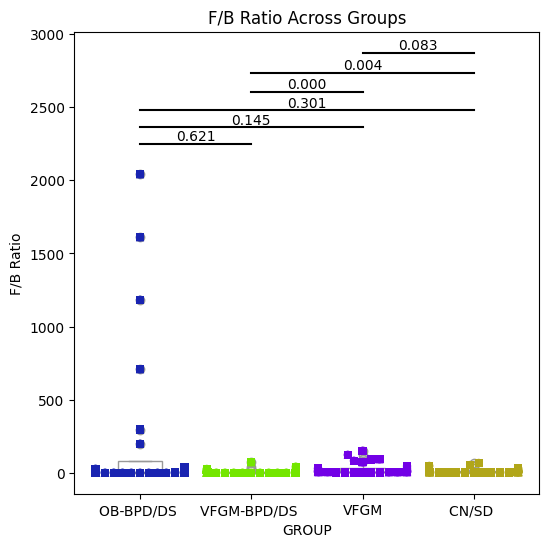

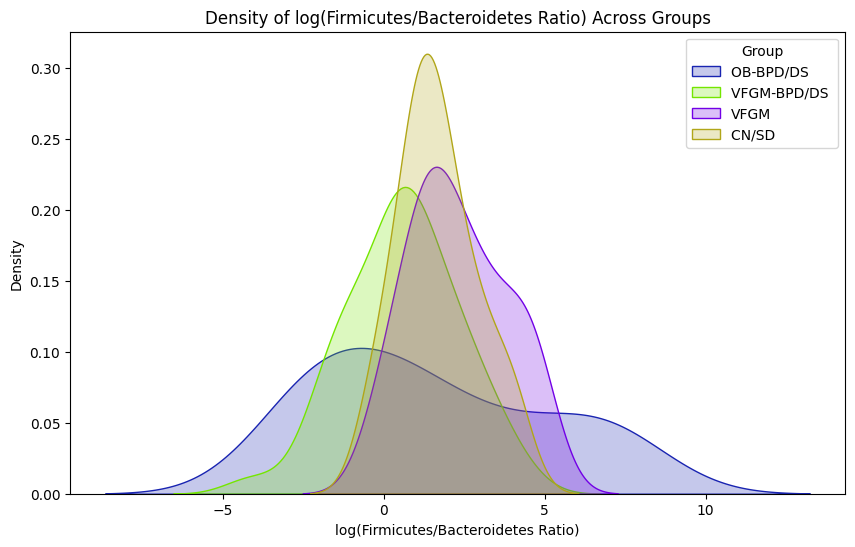

In [6]:
ma.fb_ratio_viz(df_filtered, GROUP_LIST)

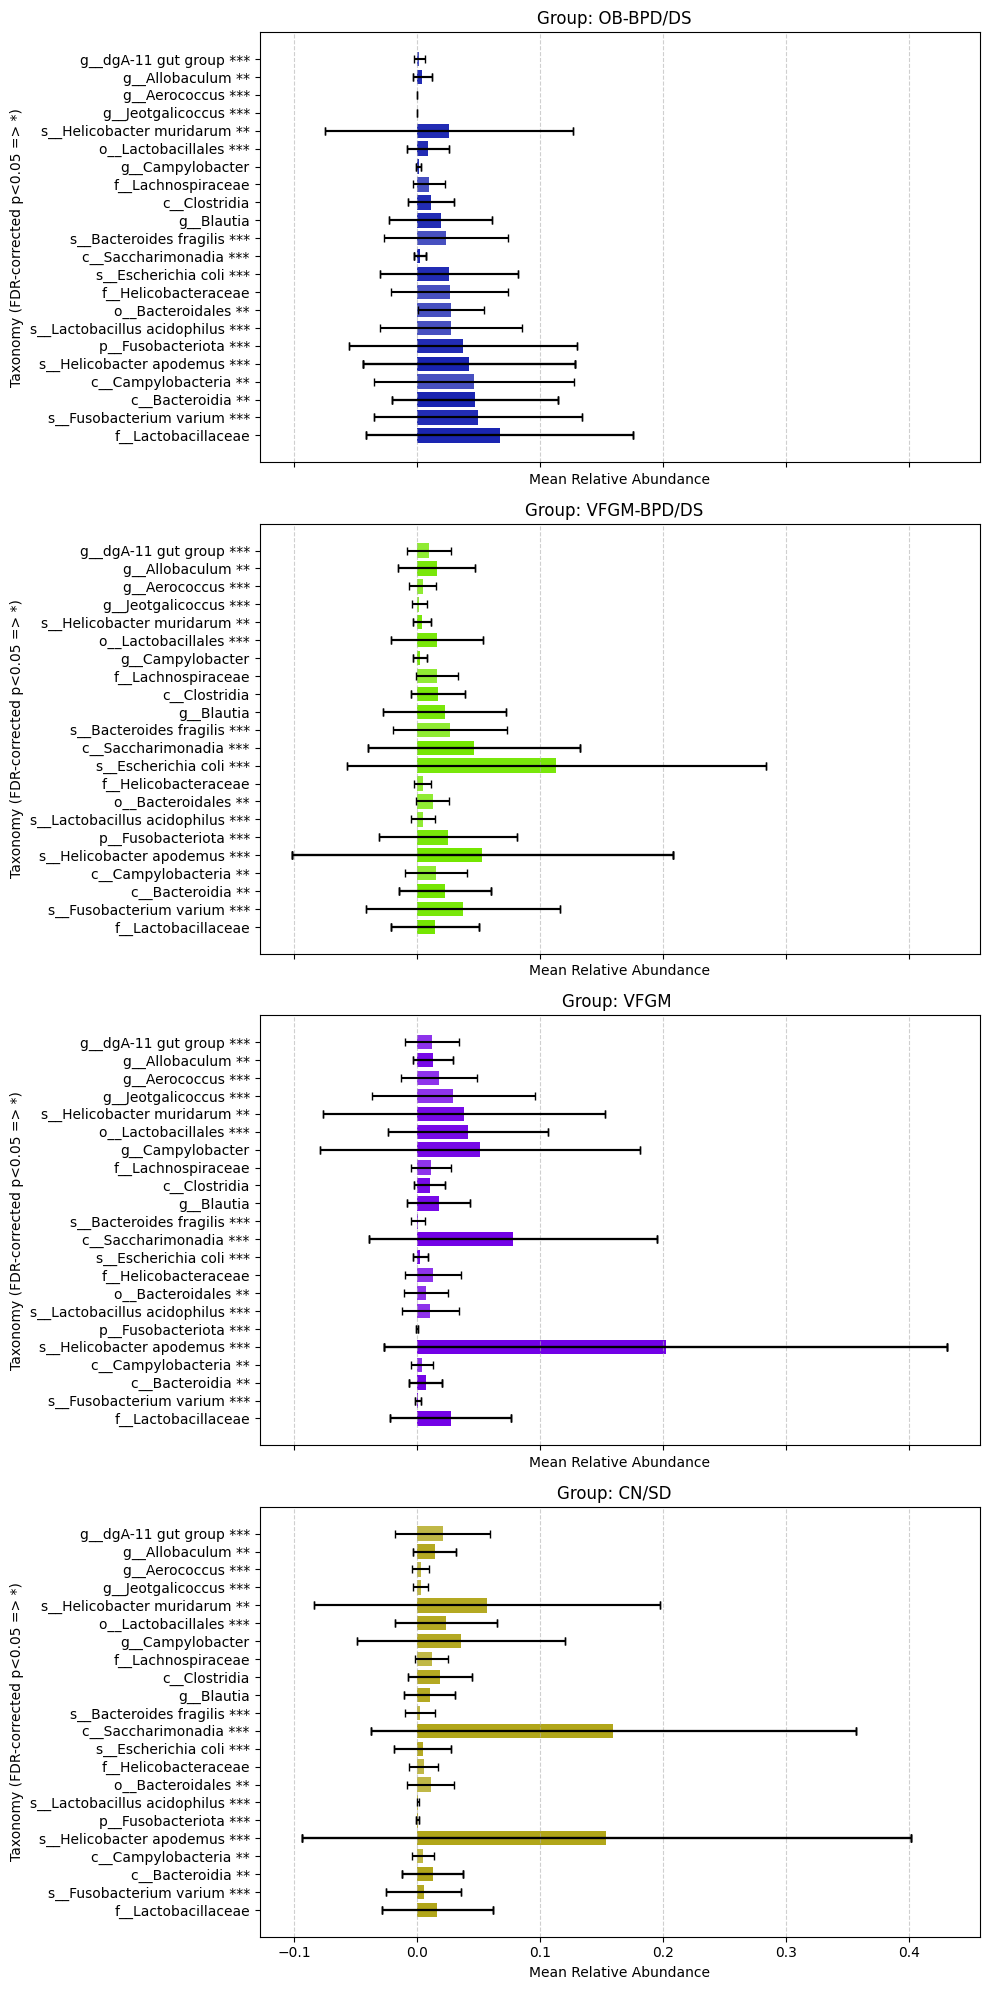

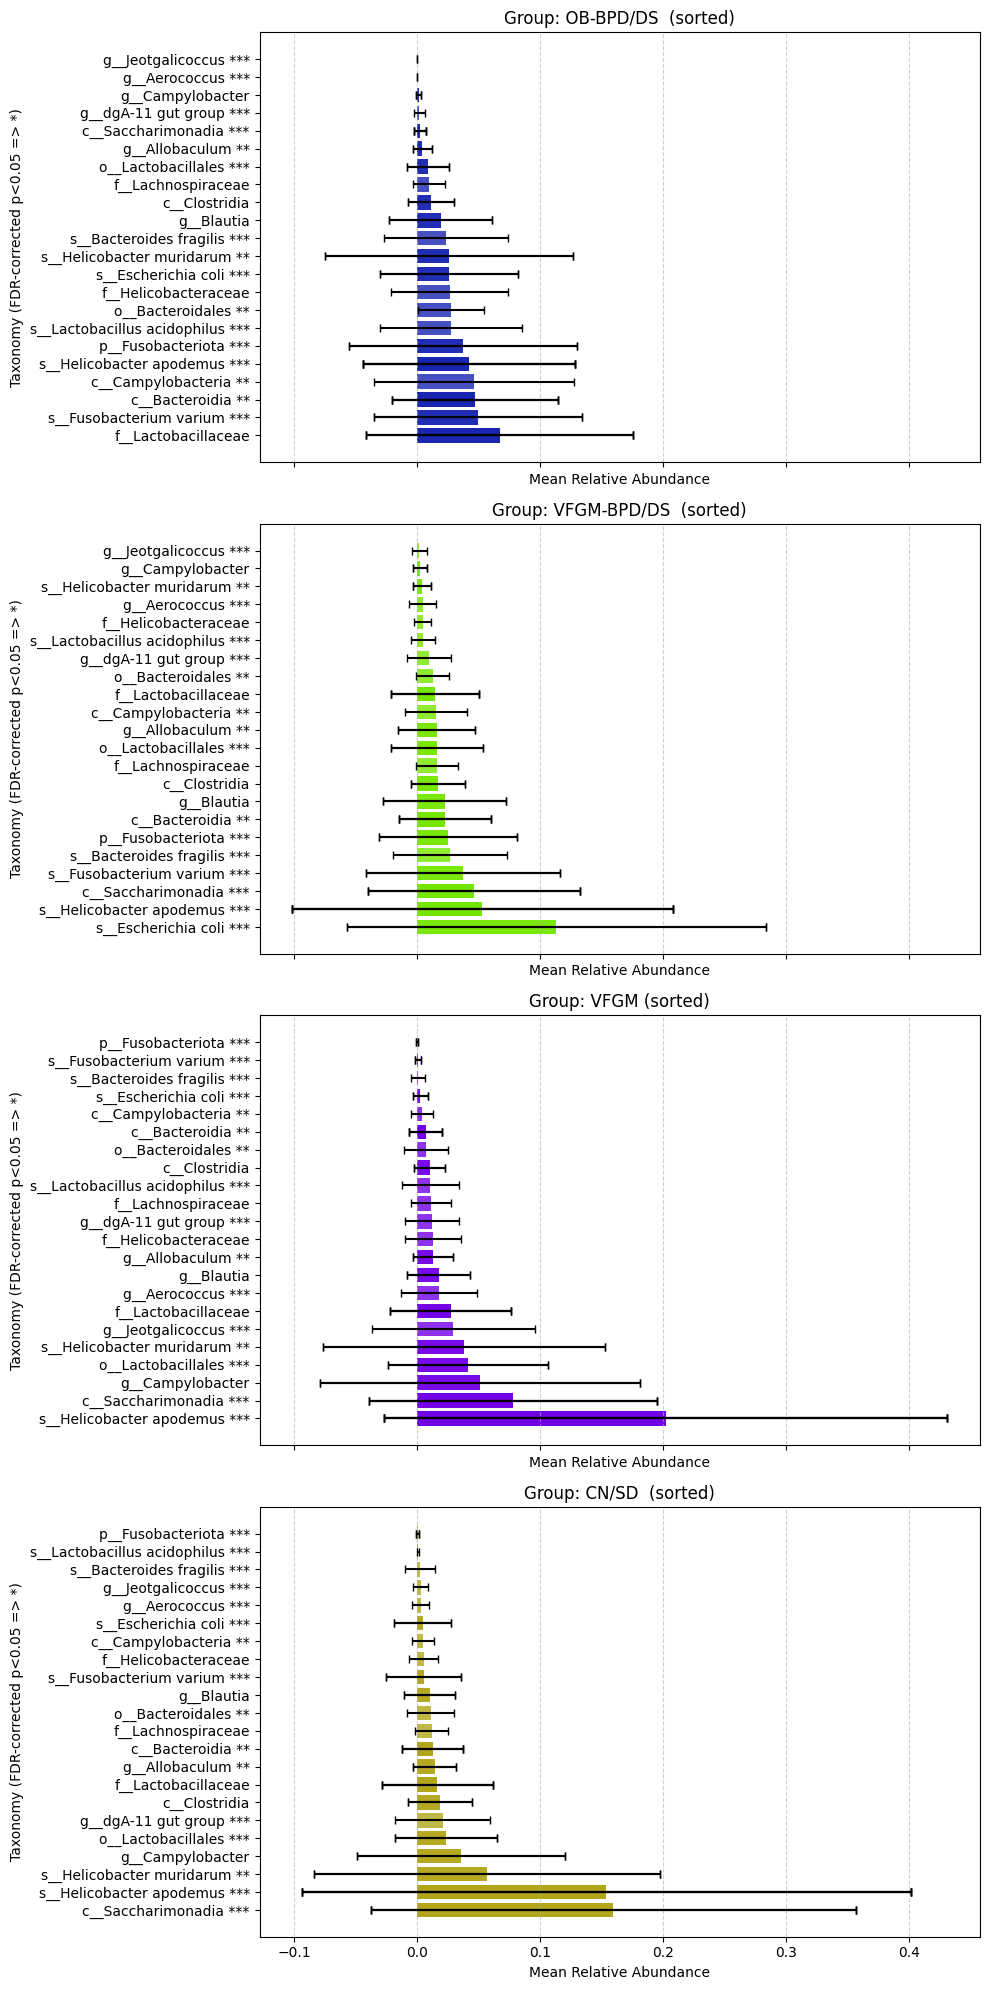

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# ====== Пример глобальных переменных (у вас могут отличаться) ======
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'rats_1'
GROUP_LIST = ['OB-BPD/DS ', 'VFGM-BPD/DS ', 'VFGM', 'CN/SD ']
GROUP_COLORS = ['#1924B1', '#74E600', '#7200e6', '#b1a619']

SAFE_DATA = True
SHOW = True

##############################################################################
# 1. Подготовка данных: считаем и mean, и std, и n.
#    Далее «топ-10» для каждой группы, объединяем все в один список.
##############################################################################

# Предполагается, что df_filtered - это ваш датафрейм с колонками:
# ['Taxonomy', 'GROUP', 'RelativeAbundance', ...]
df = df_filtered.copy()

# Упрощаем названия таксонов: берём только последний уровень
df['Taxonomy'] = df['Taxonomy'].apply(
    lambda x: x.split('|')[-1] if isinstance(x, str) else x
)

# Считаем mean, std, count для (Taxonomy, GROUP)
stats_data = df.groupby(['Taxonomy', 'GROUP'])['RelativeAbundance'].agg(['mean','std','count']).reset_index()
stats_data.columns = ['Taxonomy','GROUP','Mean','Std','Count']

# Формируем pivot-таблицы для mean и std
pivot_means = stats_data.pivot(index='Taxonomy', columns='GROUP', values='Mean').fillna(0)
pivot_stds  = stats_data.pivot(index='Taxonomy', columns='GROUP', values='Std').fillna(0)

# Выбираем топ-10 таксонов по каждому столбцу (группе)
top_taxa_lists = []
for group in GROUP_LIST:
    top_10 = pivot_means[group].nlargest(10)  # 10 самых высоких средних
    top_taxa_lists.append(top_10)

# Объединяем все выбранные таксоны 
top_taxa = pd.concat(top_taxa_lists).drop_duplicates().index

# Выбираем из сводных таблиц только нужные таксоны
plot_means = pivot_means.loc[top_taxa].copy()
plot_stds  = pivot_stds.loc[top_taxa].copy()

##############################################################################
# 2. Статистическая проверка (Kruskal-Wallis) для каждого таксона
#    Сбор всех p-значений -> корректировка FDR (multipletests).
##############################################################################

taxa_list = []
pvals_list = []

for taxon in top_taxa:
    sub_df = df[df['Taxonomy'] == taxon]
    # Собираем массивы данных по каждой группе
    data_groups = []
    for grp in GROUP_LIST:
        values = sub_df.loc[sub_df['GROUP'] == grp, 'RelativeAbundance'].dropna()
        if len(values) > 0:
            data_groups.append(values)
        else:
            # Если в одной группе нет значений для данного таксона,
            # тест Kruskal может некорректно работать, поэтому пропустим
            # или считаем p=1
            pass

    if len(data_groups) > 1:
        stat, p_val = kruskal(*data_groups)
        taxa_list.append(taxon)
        pvals_list.append(p_val)
    else:
        # Если реально нет данных
        taxa_list.append(taxon)
        pvals_list.append(1.0)

# Корректируем на множественные сравнения методом FDR (Benjamini-Hochberg)
reject, pvals_corrected, _, _ = multipletests(pvals_list, alpha=0.05, method='fdr_bh')

# Словарь вида: {taxon: скорректированный p-value}
corrected_dict = {}
for t, pval_corr in zip(taxa_list, pvals_corrected):
    corrected_dict[t] = pval_corr

##############################################################################
# 3. Помечаем таксоны звёздочками, если скорректированное p < 0.05
##############################################################################

def significance_star(p_val, alpha=0.05):
    """Возвращает строку со звёздочками в зависимости от скорректированного p_val."""
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < alpha:
        return '*'
    else:
        return ''

labels = []
for taxon in plot_means.index:
    star = significance_star(corrected_dict[taxon])
    # Добавляем звёздочки к названию таксона
    if star:
        labels.append(f"{taxon} {star}")
    else:
        labels.append(taxon)

# Создаём колонки для удобства
plot_means['Label'] = labels
plot_means.reset_index(inplace=True)
plot_stds.reset_index(inplace=True)

##############################################################################
# 4. Функции рисования: barh + ошибки (std).
#    - plot_cluster_importance         -> без сортировки
#    - plot_cluster_importance_sorted  -> с сортировкой
##############################################################################

def plot_cluster_importance(df_means, df_stds, group_labels, group_colors, title_suffix=""):
    """
    4 subplot: по 1 на каждую группу.
    Горизонтальные столбцы: mean ± std.
    По оси Y — Taxonomy (с учётом звёздочек, если p < 0.05).
    """
    fig, axes = plt.subplots(len(group_labels), 1, figsize=(10, len(group_labels)*5), sharex=True)

    for i, (group, color) in enumerate(zip(group_labels, group_colors)):
        ax = axes[i]
        # Достаем mean и std
        means = df_means.set_index('Taxonomy')[group]
        stds  = df_stds.set_index('Taxonomy')[group]

        sub_df = pd.DataFrame({
            'Taxonomy': df_means['Taxonomy'],
            'Label': df_means['Label'],
            'Mean': means.values,
            'Std':  stds.values
        }, index=df_means.index)

        ax.barh(
            y=sub_df['Label'],
            width=sub_df['Mean'],
            xerr=sub_df['Std'],
            color=color,
            ecolor='black',
            capsize=3,
            alpha=0.8
        )
        ax.set_title(f'Group: {group} {title_suffix}', fontsize=12)
        ax.set_ylabel('Taxonomy (FDR-corrected p<0.05 => *)')
        ax.set_xlabel('Mean Relative Abundance')
        ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()

    # Сохранить и/или показать
    if SAFE_DATA:
        out_path = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/Main drivers of Dirichlet/figure/dirichlet_{title_suffix}.pdf'
        plt.savefig(out_path, bbox_inches='tight')

    if SHOW:
        plt.show()

    plt.close()

def plot_cluster_importance_sorted(df_means, df_stds, group_labels, group_colors, title_suffix="(sorted)"):
    """
    То же самое, но сортируем таксоны по убыванию Mean внутри каждой группы.
    """
    fig, axes = plt.subplots(len(group_labels), 1, figsize=(10, len(group_labels)*5), sharex=True)

    for i, (group, color) in enumerate(zip(group_labels, group_colors)):
        ax = axes[i]
        means = df_means.set_index('Taxonomy')[group]
        stds  = df_stds.set_index('Taxonomy')[group]

        sub_df = pd.DataFrame({
            'Taxonomy': df_means['Taxonomy'],
            'Label': df_means['Label'],
            'Mean': means.values,
            'Std':  stds.values
        }, index=df_means.index)

        # Сортируем по убыванию Mean
        sub_df = sub_df.sort_values(by='Mean', ascending=False)

        ax.barh(
            y=sub_df['Label'],
            width=sub_df['Mean'],
            xerr=sub_df['Std'],
            color=color,
            ecolor='black',
            capsize=3,
            alpha=0.8
        )
        ax.set_title(f'Group: {group} {title_suffix}', fontsize=12)
        ax.set_ylabel('Taxonomy (FDR-corrected p<0.05 => *)')
        ax.set_xlabel('Mean Relative Abundance')
        ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()

    if SAFE_DATA:
        out_path = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/Main drivers of Dirichlet/figure/dirichlet_sorted.pdf'
        plt.savefig(out_path, bbox_inches='tight')

    if SHOW:
        plt.show()

    plt.close()

##############################################################################
# 5. Запуск визуализации
##############################################################################
plot_cluster_importance(plot_means, plot_stds, GROUP_LIST, GROUP_COLORS, title_suffix="")
plot_cluster_importance_sorted(plot_means, plot_stds, GROUP_LIST, GROUP_COLORS, title_suffix="(sorted)")


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def stack_plot_test(taxon_abundance, pairs, name_suffix='', orientation='vertical'):
    """
    Строит stacked bar plot для топ-10 таксонов с использованием matplotlib,
    с учётом множественных сравнений (FDR).

    Параметры:
      - taxon_abundance: DataFrame с колонками 'GROUP', 'Taxonomy' и 'Value'.
      - pairs: список групп для включения (например, ['Group1','Group2']).
      - name_suffix: суффикс для сохранения/отображения.
      - orientation: 'vertical' или 'horizontal'.

    Возвращает:
      dict: {taxon: скорректированное p-value}, где p-value после FDR-коррекции.
    """
    # Фильтруем нужные группы
    filtered_abundance = taxon_abundance[taxon_abundance['GROUP'].isin(pairs)]
    
    # Считаем среднюю абундантность (Value) по (GROUP, Taxonomy)
    mean_abundance = filtered_abundance.groupby(['GROUP', 'Taxonomy'])['Value'].mean().reset_index()
    mean_abundance['Value'] = pd.to_numeric(mean_abundance['Value'], errors='coerce')

    # Отбираем топ-10 таксонов по сумме mean среди всех групп
    top_taxa = mean_abundance.groupby('Taxonomy')['Value'].sum().nlargest(10).index
    top_taxon_abundance = mean_abundance[mean_abundance['Taxonomy'].isin(top_taxa)]

    # ======================================
    # 1) Собираем p-value для каждого таксона
    #    (Kruskal-Wallis по всем выбранным группам)
    # ======================================
    pvals_list = []
    taxa_list = []
    
    for taxon in top_taxa:
        sub_df = filtered_abundance[filtered_abundance['Taxonomy'] == taxon]
        grouped_data = [
            sub_df.loc[sub_df['GROUP'] == g, 'Value'].dropna().values
            for g in pairs
        ]
        # Если есть хотя бы 2 группы с данными
        if sum(len(arr) > 0 for arr in grouped_data) >= 2:
            stat, p_val = kruskal(*grouped_data)
        else:
            p_val = 1.0  # нет данных или 1 группа
        pvals_list.append(p_val)
        taxa_list.append(taxon)

    # ======================================
    # 2) Корректируем p-value (FDR, Benjamini-Hochberg)
    # ======================================
    reject, pvals_corrected, _, _ = multipletests(pvals_list, alpha=0.05, method='fdr_bh')
    p_values_fdr = dict(zip(taxa_list, pvals_corrected))

    # ======================================
    # 3) Подготовка легенды (таксон + звёздочки)
    # ======================================
    def star_label(pval):
        if pval < 0.001:
            return '***'
        elif pval < 0.01:
            return '**'
        elif pval < 0.05:
            return '*'
        return ''

    legend_labels = []
    for taxon in top_taxa:
        label = taxon + ' ' + star_label(p_values_fdr[taxon])
        legend_labels.append(label)

    # ======================================
    # 4) Формируем pivot-таблицу и рисуем
    # ======================================
    pivot_table = top_taxon_abundance.pivot_table(
        index='GROUP', columns='Taxonomy', values='Value', aggfunc='mean'
    )
    pivot_table = pivot_table.reindex(pairs)
    pivot_table = pivot_table[top_taxa]  # порядок столбцов = top_taxa

    # Цвета
    colors = sns.color_palette('deep', n_colors=len(top_taxa))
    taxa_colors = dict(zip(top_taxa, colors))

    fig, ax = plt.subplots(figsize=(2, 5))
    plot_kind = 'barh' if orientation == 'horizontal' else 'bar'

    pivot_table.plot(
        kind=plot_kind, stacked=True,
        color=[taxa_colors[t] for t in top_taxa],
        width=1, edgecolor='white', ax=ax
    )

    ax.set_title(f'Top 10 Taxa {name_suffix}')
    if orientation == 'vertical':
        ax.set_ylabel('Percentage of Relative Abundance')
        ax.set_xlabel('Groups')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    else:
        ax.set_xlabel('Percentage of Relative Abundance')
        ax.set_ylabel('Groups')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

    ax.set_facecolor('none')
    fig.set_facecolor('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Создаём легенду вручную
    patches = [
        plt.Rectangle((0,0),1,1, color=taxa_colors[taxon]) 
        for taxon in top_taxa
    ]
    plt.legend(
        patches, legend_labels, 
        title="Taxa Categories",
        bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False
    )

    plt.tight_layout()

    # Сохраняем/показываем если надо
    from microbiome_analysis import SAFE_DATA, SHOW, PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA, PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE, NAME_DF
    if SAFE_DATA:
        # Сохраняем pivot_table и p_values
        pivot_table.to_excel(f'{PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA}/{NAME_DF}_{name_suffix}_relative_abundance.xlsx', index=True)
        plt.savefig(f'{PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE}/{NAME_DF}_stack_{name_suffix}.pdf', bbox_inches='tight')
        with open(f'{PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA}/p_values_{name_suffix}.txt', 'w') as file:
            for tx in top_taxa:
                file.write(f"{tx}\tfdr_pval={p_values_fdr[tx]}\n")

    if SHOW:
        plt.show()

    plt.close()
    return p_values_fdr

def mean_plotbars(df, name_suffix, group_orders, relative='RelativeAbundance', height=0.1):
    """
    Строит столбчатую диаграмму (bar plot) с error bars и аннотациями значимости (FDR) для топ-10 таксонов.
    
    Параметры:
      - df: DataFrame с колонками 'Taxonomy', 'GROUP' и relative (например, 'RelativeAbundance').
      - name_suffix: суффикс для сохранения графика.
      - group_orders: порядок групп для отображения (список).
      - relative: имя колонки с относительной абундантностью (по умолч. 'RelativeAbundance').
      - height: смещение для аннотаций по оси Y.
    
    Возвращает:
      pd.DataFrame: датафрейм с добавленной колонкой 'StdDev', содержащей std по таксонам.
                    (и включающий только top-10 таксонов).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import kruskal
    from statsmodels.stats.multitest import multipletests
    import numpy as np

    from microbiome_analysis import SAFE_DATA, SHOW, PALETTE, PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE, NAME_DF

    # 1) Считаем std по каждому таксону
    std_devs_per_taxonomy = df.groupby('Taxonomy')[relative].std().fillna(0)

    # 2) Объединяем std в таблицу
    df_with_std_dev = df.merge(std_devs_per_taxonomy.rename('StdDev'), on='Taxonomy', how='left')

    # 3) Выбираем top-10 таксонов по среднему
    top_taxa = df.groupby('Taxonomy')[relative].mean().nlargest(10).index
    df_with_std_dev = df_with_std_dev[df_with_std_dev['Taxonomy'].isin(top_taxa)]

    # =====================================
    # (A) Собираем p-values (Kruskal) для каждого таксона
    # =====================================
    taxon_list = []
    pvals_list = []
    for taxon in top_taxa:
        sub_df = df_with_std_dev[df_with_std_dev['Taxonomy'] == taxon]
        # Собираем данные по группам
        data_groups = []
        for grp in group_orders:
            values = sub_df.loc[sub_df['GROUP'] == grp, relative].dropna().values
            data_groups.append(values)
        # Если хотя бы 2 группы не пусты
        if sum(len(arr) > 0 for arr in data_groups) >= 2:
            stat, p_val = kruskal(*data_groups)
        else:
            p_val = 1.0
        taxon_list.append(taxon)
        pvals_list.append(p_val)

    # Применяем FDR
    reject, pvals_fdr, _, _ = multipletests(pvals_list, alpha=0.05, method='fdr_bh')
    fdr_dict = dict(zip(taxon_list, pvals_fdr))

    # =====================================
    # Рисуем barplot (Seaborn)
    # =====================================
    plt.figure(figsize=(10, 9))
    sns.barplot(
        x='Taxonomy',
        y=relative,
        hue='GROUP',
        data=df_with_std_dev,
        palette=PALETTE,
        alpha=0.5,
        capsize=0.1,
        errwidth=1,
        width=0.8,
        hue_order=group_orders
    )

    # =====================================
    # (B) Добавляем собственные error bars + раскраску
    # (плюс ставим звёздочки)
    # =====================================
    unique_taxa = df_with_std_dev['Taxonomy'].unique()
    
    # Чтобы в том же порядке, как на оси X: 
    # unique_taxa может быть в произвольном порядке, 
    # но barplot расставляет категории по алфавиту, если не задан order=...
    # Для корректного обхода можно взять sorted(unique_taxa, key=lambda x: ...)
    # Или просто используем enumerate(unique_taxa) как ниже.

    x_positions = {tax: i for i, tax in enumerate(unique_taxa)}

    for i, taxon in enumerate(unique_taxa):
        mean_val = df_with_std_dev.loc[df_with_std_dev['Taxonomy'] == taxon, relative].mean()
        std_val  = std_devs_per_taxonomy[taxon]

        # добавляем errorbar "вручную":
        plt.errorbar(
            x=x_positions[taxon],
            y=mean_val,
            yerr=std_val,
            fmt='none',
            ecolor='k',
            capsize=3,
        )

        # Добавляем фон, если хотим чередование полос
        background_color = 'white' if i % 2 else 'gray'
        plt.axvspan(i - 0.5, i + 0.5, color=background_color, alpha=0.05)

        # Ставим звёздочки сверху
        p_val_fdr = fdr_dict.get(taxon, 1.0)
        if p_val_fdr < 0.001:
            stars = '***'
        elif p_val_fdr < 0.01:
            stars = '**'
        elif p_val_fdr < 0.05:
            stars = '*'
        else:
            stars = ''

        if stars:
            y_top = df_with_std_dev[relative].max()
            plt.text(
                x_positions[taxon], y_top + height,
                stars, ha='center', va='bottom',
                color='black', fontsize=10
            )

    # Горизонтальная линия по 0 (на случай, если значения могут быть < 0)
    custom_dash = [20, 5, 20, 5]
    plt.axhline(0, color='black', linewidth=1, dashes=custom_dash, alpha=0.5)

    plt.xticks(rotation=60, ha='right')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Taxonomy')
    plt.ylabel(relative)
    plt.title(f'Relative Abundance of Taxonomies in Different Groups ({name_suffix})')
    plt.legend(title='GROUP', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=0.1)
    plt.tight_layout()

    if SAFE_DATA:
        plt.savefig(f'{PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE}/mean_plot_{name_suffix}_{relative}.pdf', 
                    bbox_inches='tight')

    if SHOW:
        plt.show()

    plt.close()
    return df_with_std_dev



In [9]:
def shorten_taxonomy(taxon_str):
    if isinstance(taxon_str, str):
        return taxon_str.split('|')[-1]
    return taxon_str



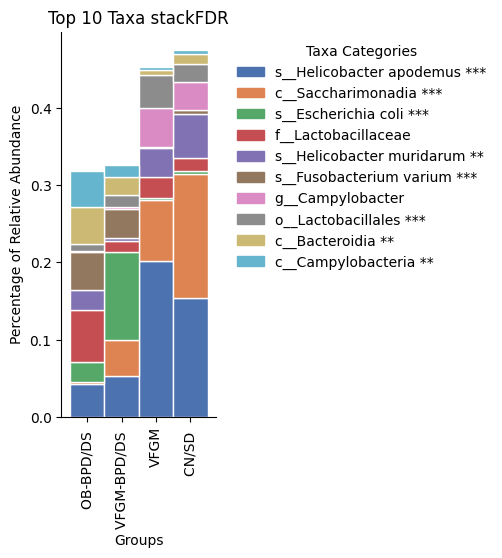

Stack plot test p-values (FDR) => {'s__Helicobacter apodemus': 0.00046512938873490147, 'c__Saccharimonadia': 2.2204814981019768e-11, 's__Escherichia coli': 2.9301688086545287e-08, 'f__Lactobacillaceae': 0.3575277625851452, 's__Helicobacter muridarum': 0.005737347656991345, 's__Fusobacterium varium': 4.6318246160996447e-10, 'g__Campylobacter': 0.11232471439398548, 'o__Lactobacillales': 0.000635941995783018, 'c__Bacteroidia': 0.0023023957322167708, 'c__Campylobacteria': 0.0031293515249773383}


In [10]:
df_stack = df_filtered[['GROUP','Taxonomy','RelativeAbundance']].copy()
df_stack.rename(columns={'RelativeAbundance':'Value'}, inplace=True)

df_stack['Taxonomy'] = df_stack['Taxonomy'].apply(shorten_taxonomy)
# Вызываем stack_plot_test
pvals_fdr_stack = stack_plot_test(
    taxon_abundance=df_stack,
    pairs=GROUP_LIST,
    name_suffix='stackFDR',
    orientation='vertical'
)
print("Stack plot test p-values (FDR) =>", pvals_fdr_stack)

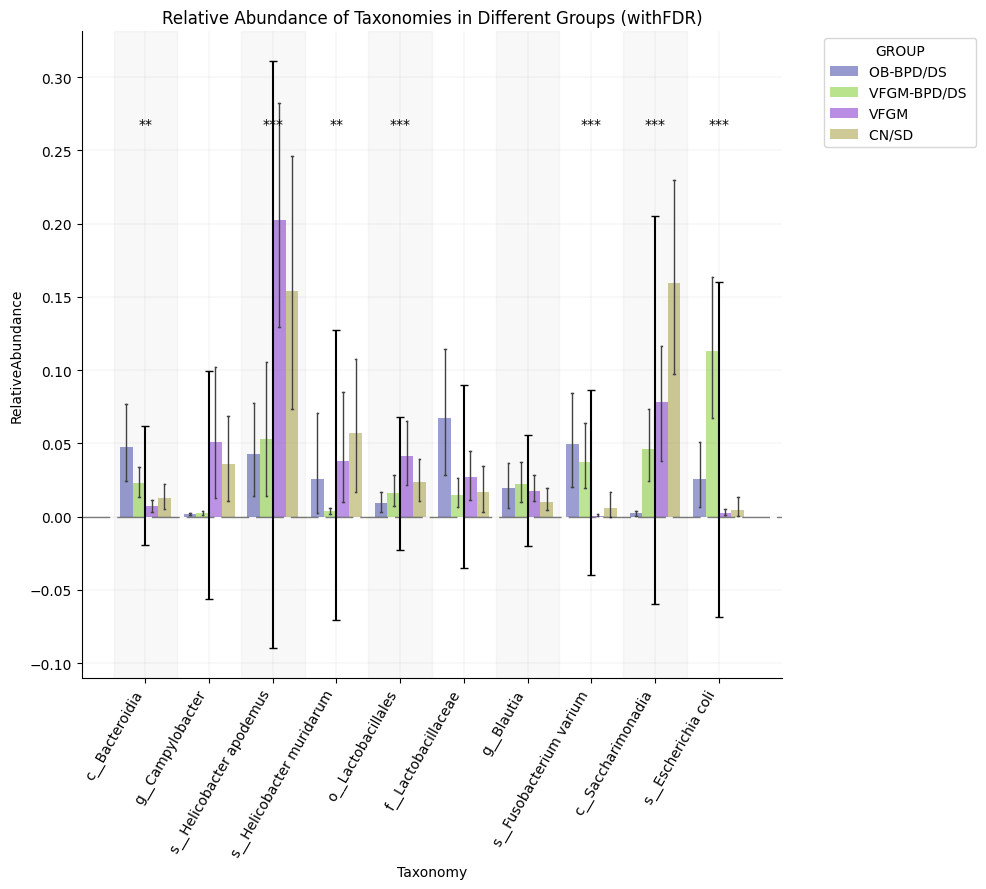

Mean plotbars DF shape = (1330, 7)


In [11]:
df_mean = df_filtered.copy()
df_mean['Taxonomy'] = df_mean['Taxonomy'].apply(shorten_taxonomy)

meanbars_df = mean_plotbars(
    df=df_mean,
    name_suffix='withFDR',
    group_orders=GROUP_LIST,
    relative='RelativeAbundance',
    height=-0.6
)
print("Mean plotbars DF shape =", meanbars_df.shape)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kruskal, mannwhitneyu

def mean_difference_analysis(
    df,
    value_col='RelativeAbundance',
    group_col='GROUP',
    taxonomy_col='Taxonomy',
    top_n=10,
    group_orders=None,
    palette=None,
    output_file=None,
    show_plot=True
):
    """
    Анализ разницы средних значений между группами и построение графиков столбцов с указанием ошибок.

    Параметры:
    - df: pandas DataFrame с данными.
    - value_col: str, название столбца с анализируемыми значениями.
    - group_col: str, название столбца с метками групп.
    - taxonomy_col: str, название столбца с таксономией.
    - top_n: int, количество топовых категорий для включения на основе средних значений.
    - group_orders: list, порядок отображения групп.
    - palette: dict или list, цветовая палитра для групп.
    - output_file: str, путь для сохранения графика.
    - show_plot: bool, отображать ли график.
    """

    # Преобразуем столбец taxonomy_col, оставляя только последнюю часть после '|'
    df[taxonomy_col] = df[taxonomy_col].apply(lambda x: x.split('|')[-1] if isinstance(x, str) else x)
    
    # Фильтрация таксонов по порогам абундантности, стандартного отклонения и значимости
    abundance_threshold = 0.001
    std_threshold = 0.005
    significance_threshold = 0.05

    means = df.groupby(taxonomy_col)[value_col].mean()
    std_devs = df.groupby(taxonomy_col)[value_col].std()

    # Первичная фильтрация по среднему значению и стандартному отклонению
    filtered_taxa = means[(means > abundance_threshold) & (std_devs > std_threshold)].index

    # Фильтрация по статистической значимости
    significant_taxa = []
    for taxon in filtered_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        data = [df_taxon.loc[df_taxon[group_col] == group, value_col].values for group in group_orders]

        # Если данные для таксона присутствуют в каждой группе, выполняем тест
        if all([len(d) > 0 for d in data]):
            _, p_value = kruskal(*data)
            if p_value < significance_threshold:
                significant_taxa.append(taxon)

    # Добавляем g_Bacteroides в список значимых таксонов, если он присутствует в данных
    if 'g_Bacteroides' in df[taxonomy_col].values:
        significant_taxa.append('g_Bacteroides')

    # Оставляем только значимые таксоны
    df = df[df[taxonomy_col].isin(significant_taxa)]

    # Преобразуем столбец group_col в категориальный тип с указанием порядка категорий
    df[group_col] = pd.Categorical(df[group_col], categories=group_orders, ordered=True)
    
    # Рассчитываем средние значения и стандартные отклонения после фильтрации
    means = df.groupby(taxonomy_col)[value_col].mean()
    std_devs = df.groupby(taxonomy_col)[value_col].std().fillna(0)

    # Выбираем top_n таксонов на основе средних значений
    top_taxa = means.nlargest(top_n).index
    df_top = df[df[taxonomy_col].isin(top_taxa)]

    # Добавляем стандартные отклонения в DataFrame
    df_top = df_top.merge(std_devs.rename('StdDev'), on=taxonomy_col, how='left')

    # Определяем количество строк и столбцов для графиков (сетка)
    num_cols = 4  # Можно изменить в зависимости от предпочтений
    num_rows = int(np.ceil(len(top_taxa) / num_cols))

    # Создаем подграфики
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4.5), sharey=False)
    axes = axes.flatten()

    for i, taxon in enumerate(top_taxa):
        ax = axes[i]

        # Фильтруем данные для текущего таксона
        df_taxon = df_top[df_top[taxonomy_col] == taxon]

        # Столбчатая диаграмма
        sns.barplot(
            x=group_col,
            y=value_col,
            data=df_taxon,
            palette=palette,
            ax=ax,
            capsize=0.1,
            errwidth=1,
            ci='sd',
            hue_order=group_orders
        )

        # Тестирование каждой пары групп с помощью теста Манна-Уитни
        import itertools
        group_combinations = list(itertools.combinations(group_orders, 2))
        p_value_matrix = pd.DataFrame(index=group_orders, columns=group_orders)

        # Заполняем матрицу p-value для каждой пары
        for group1, group2 in group_combinations:
            data1 = df_taxon.loc[df_taxon[group_col] == group1, value_col].values
            data2 = df_taxon.loc[df_taxon[group_col] == group2, value_col].values
            if len(data1) > 0 and len(data2) > 0:
                _, p_val = mannwhitneyu(data1, data2)
                p_value_matrix.loc[group1, group2] = p_val
                p_value_matrix.loc[group2, group1] = p_val

        # Отрисовываем линии и добавляем текст с p-value
        y_offset = df_taxon[value_col].max() * 0.8  # Отступ от максимального значения
        y_step = y_offset * 0.15  # Шаг по оси Y для каждой линии
        y_range = df_taxon[value_col].max() - df_taxon[value_col].min()

        for idx, (group1, group2) in enumerate(group_combinations):
            p_val = p_value_matrix.loc[group1, group2]
            if p_val < 0.05:
                x1 = group_orders.index(group1)
                x2 = group_orders.index(group2)
                y = (y_offset + idx * y_step)*0.9 
                ax.plot([x1, x1, x2, x2], [y*1.05, y + y_step/2, y + y_step/2, y*1.05], lw=1.5, c='black')  # Используем ax для правильной отрисовки
                p_val_text = f"p = {p_val:.4f}" if p_val >= 0.001 else "p < 0.001"
                ax.text((x1 + x2) / 2, y + y_step/2 + y_range*0.005, p_val_text, ha='center', va='bottom', color='black')

        # Настройки для каждого графика
        ax.set_title(taxon)
        ax.set_xlabel('')

    # Удаляем лишние пустые графики
    for i in range(len(top_taxa), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    # Сохранение или отображение графика
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    if show_plot:
        plt.show()
    plt.close()

    return df_top



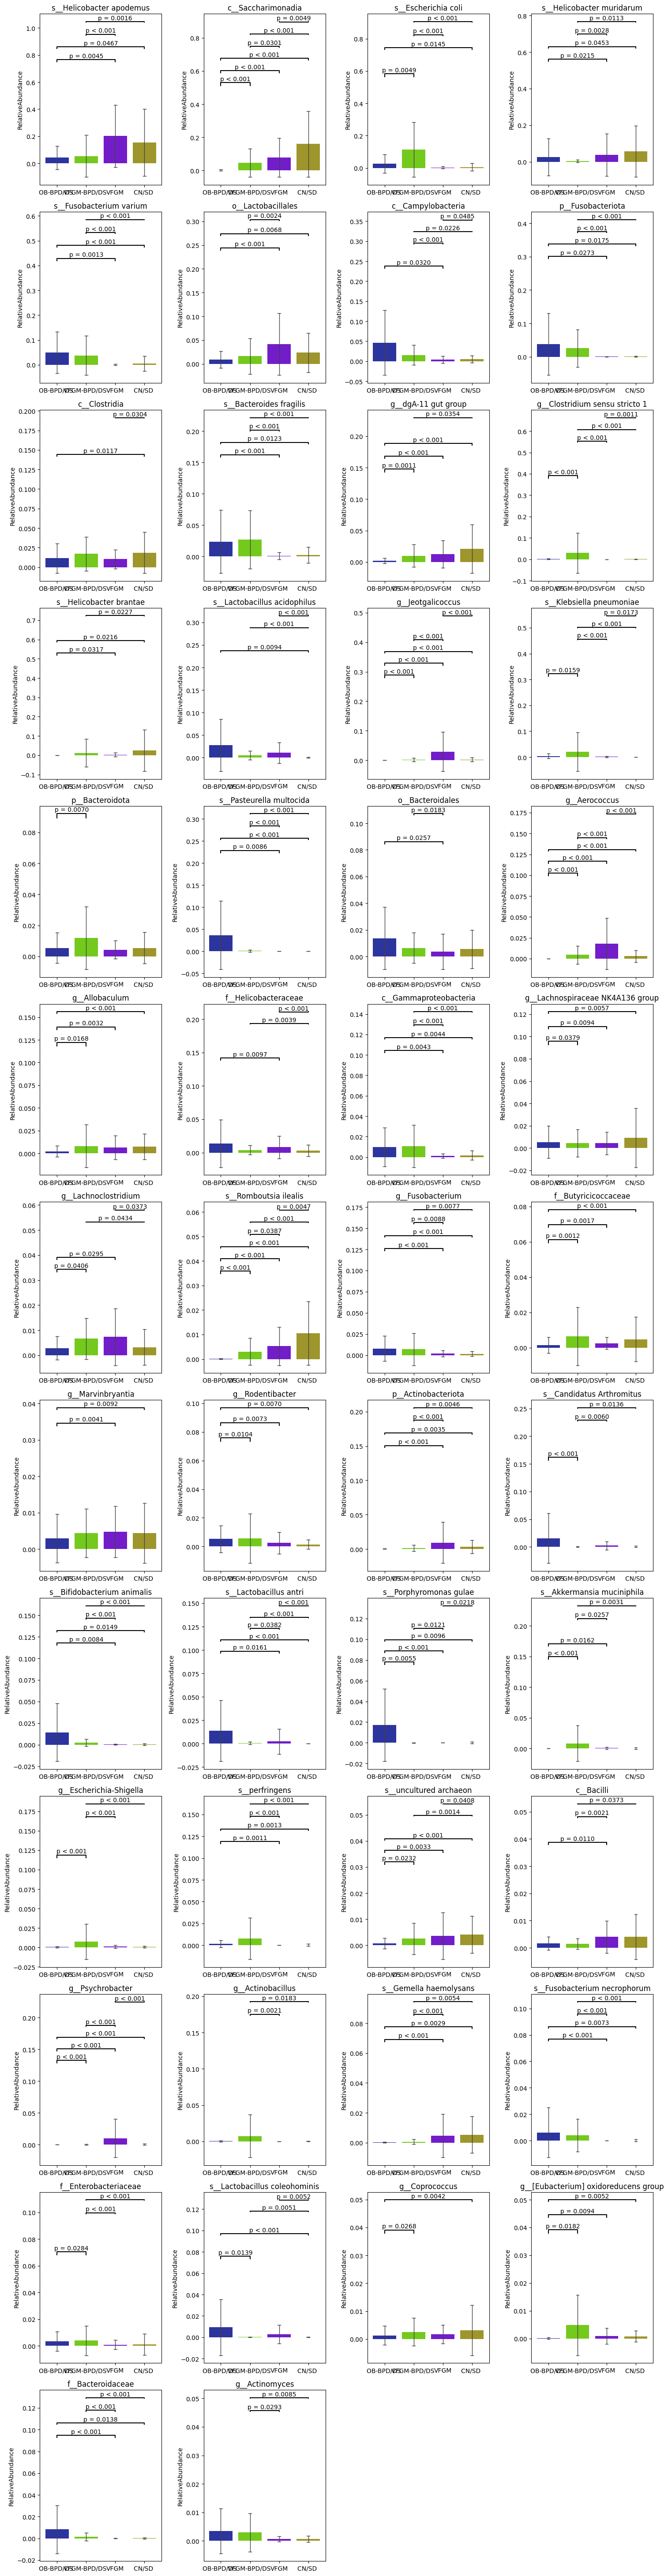

In [13]:
group_orders = GROUP_LIST
palette = PALETTE
filtered_df = DF[DF['GROUP'].isin(GROUP_LIST)]


import warnings

warnings.filterwarnings('ignore')

df_difinmeans = mean_difference_analysis(
    df=filtered_df,
    value_col='RelativeAbundance',
    group_col='GROUP',
    taxonomy_col='Taxonomy',
    top_n=50,
    group_orders=group_orders,
    palette=palette,
    output_file='mean_difference_plot.pdf',
    show_plot=True
)